# RentinBo

The aim of this project is to train a RandomForestClassifier on our dataset in order to predict in which class, or range, of euros a combination of features would fall.

## 1. Check the dataset

First of all we have to be sure that our features can be read and used by the algorithm.

In [351]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import uniform, truncnorm, randint
from pprint import pprint

In [352]:
dataset = pd.read_csv('ready_dataset.csv')

In [353]:
dataset = dataset.drop(columns = 'Unnamed: 0')
dataset

,tipologia,genere,zona,bagno,cucina,salotto,balcone,range euro
0,doppia,F,Murri,2,1,0,0,200-225
1,doppia,F,Marconi,2,1,1,0,225-250
2,doppia,M/F,Bolognina,1,1,1,0,250-275
3,singola,F,S.Vitale,1,1,0,1,400-425
4,singola,F,Irnerio,1,1,0,1,500-525
...,...,...,...,...,...,...,...,...
195,doppia,M,Irnerio,1,1,0,0,200-225
196,doppia,M/F,Bolognina,2,1,1,1,225-250
197,doppia,M/F,Bolognina,1,1,1,1,225-250
198,singola,M/F,San Donato,1,1,0,0,350-375


In [354]:
dataset.dtypes

tipologia     object
genere        object
zona          object
bagno          int64
cucina         int64
salotto        int64
balcone        int64
range euro    object
dtype: object

As we can see some of the values are categorical, others are numerical. RFC accepts only numerical values, so we have to do some transformation. 

## 2. Categorical features transformation

We are going to use a One Hot Encoding method for the dataframe for those features that are not numerical ('tipologia', 'genere', 'zona'). This will increase considerably the dimension of our dataset, but it is way quicker than replacing each feature in the rows manually.

In [355]:
dummy_dataset = pd.get_dummies(dataset, columns = ['tipologia', 'genere', 'zona'])
dummy_dataset

,bagno,cucina,salotto,balcone,range euro,tipologia_doppia,tipologia_singola,genere_F,genere_M,genere_M/F,...,zona_Lame,zona_Malpighi,zona_Marconi,zona_Mazzini,zona_Murri,zona_S.Ruffillo,zona_S.Viola,zona_S.Vitale,zona_Saffi,zona_San Donato
0,2,1,0,0,200-225,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1,1,0,225-250,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,1,1,0,250-275,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,400-425,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,0,1,500-525,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,1,0,0,200-225,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
196,2,1,1,1,225-250,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
197,1,1,1,1,225-250,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
198,1,1,0,0,350-375,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Just to split the values in our dataframe  between a features array and a target array we move the 'range euro' column to the end of the dataset.

In [356]:
columns = list(dummy_dataset.columns.values)
columns.pop(columns.index('range euro')) 
dummy_dataset = dummy_dataset[columns+['range euro']]
dummy_dataset

,bagno,cucina,salotto,balcone,tipologia_doppia,tipologia_singola,genere_F,genere_M,genere_M/F,zona_Barca,...,zona_Malpighi,zona_Marconi,zona_Mazzini,zona_Murri,zona_S.Ruffillo,zona_S.Viola,zona_S.Vitale,zona_Saffi,zona_San Donato,range euro
0,2,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,200-225
1,2,1,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,225-250
2,1,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,250-275
3,1,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,400-425
4,1,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,500-525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,200-225
196,2,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,225-250
197,1,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,225-250
198,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,350-375


We can double check for correlations between features now, as we have done beafore in 'data_preparation.ipynb'.

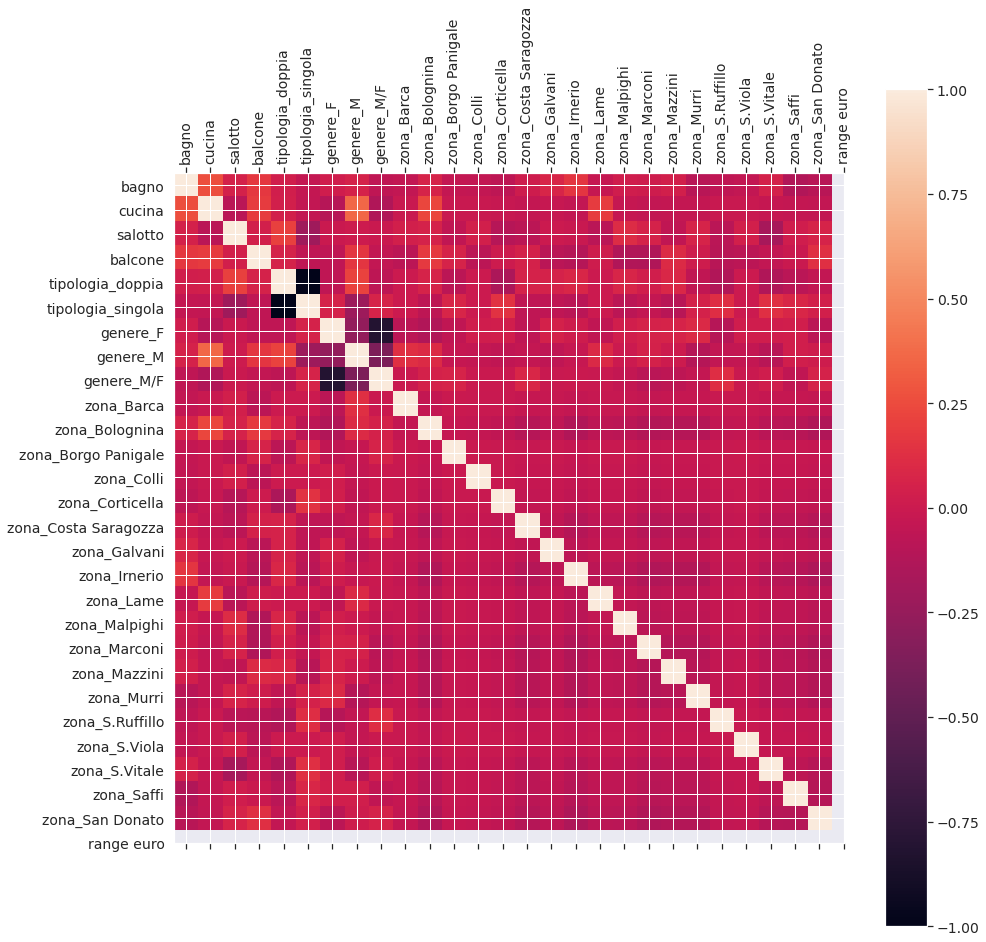

In [357]:
correlations = dummy_dataset.corr(method='pearson')
correlations
f = plt.figure(figsize=(15, 15))
plt.matshow(correlations, fignum=f.number)
plt.xticks(range(dummy_dataset.shape[1]), dummy_dataset.columns, fontsize=14, rotation=90)
plt.yticks(range(dummy_dataset.shape[1]), dummy_dataset.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

It is at least visually evident that there are not strong correlations, apart from those features like kind of bedroom and gender wich are obviously mutually excluding, thus resulting in a strong anti-correlation.

It will be interesting later to see how the 'range euro' target is correlated with features.

In [358]:
array = dummy_dataset.values
X_enc = array[:,0:27]
X_enc

array([[2, 1, 0, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0]], dtype=object)

In [359]:
Y = array[:,27]
Y

array(['200-225', '225-250', '250-275', '400-425', '500-525', '250-275',
       '500-525', '450-475', '325-350', '450-475', '350-375', '275-300',
       '225-250', '350-375', '350-375', '200-225', '400-425', '225-250',
       '250-275', '275-300', '500-525', '225-250', '300-325', '250-275',
       '325-350', '400-425', '325-350', '300-325', '400-425', '250-275',
       '225-250', '450-475', '225-250', '350-375', '200-225', '300-325',
       '350-375', '275-300', '550-575', '200-225', '250-275', '250-275',
       '400-425', '400-425', '350-375', '650-675', '300-325', '275-300',
       '375-400', '350-375', '300-325', '400-425', '275-300', '225-250',
       '200-225', '400-425', '225-250', '250-275', '550-575', '300-325',
       '200-225', '450-475', '350-375', '375-400', '425-450', '275-300',
       '275-300', '300-325', '375-400', '375-400', '175-200', '375-400',
       '225-250', '350-375', '250-275', '250-275', '400-425', '400-425',
       '450-475', '450-475', '300-325', '450-475', 

## 3. Target transformation

Even the target array has to be transformed in order to pass it to the fit() function, but we are going to use a Label Encoder wich is more suited for target values.

In [360]:
le = preprocessing.LabelEncoder()
le.fit_transform(['175-200', '200-225', '225-250', '250-275', '275-300', '300-325', '325-350', '350-375',
                  '375-400', '400-425', '425-450', '450-475', '475-500', '500-525', '525-550', '550-575', 
                 '575-600', '600-625', '625-650', '650-675', '675-700'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [361]:
le.transform(Y)

array([ 1,  2,  3,  9, 13,  3, 13, 11,  6, 11,  7,  4,  2,  7,  7,  1,  9,
        2,  3,  4, 13,  2,  5,  3,  6,  9,  6,  5,  9,  3,  2, 11,  2,  7,
        1,  5,  7,  4, 15,  1,  3,  3,  9,  9,  7, 19,  5,  4,  8,  7,  5,
        9,  4,  2,  1,  9,  2,  3, 15,  5,  1, 11,  7,  8, 10,  4,  4,  5,
        8,  8,  0,  8,  2,  7,  3,  3,  9,  9, 11, 11,  5, 11, 15,  9,  7,
        2,  9, 11,  7,  6,  3,  8,  7, 11,  6,  8,  3,  3,  4,  1,  3, 14,
        8, 10,  3,  5,  5,  6,  2,  5,  5,  6,  4,  5,  7,  5,  5, 13,  7,
        9,  9,  6, 11, 11,  3,  7,  5, 11,  2,  9,  4,  5,  3, 11, 10,  3,
        9,  1, 13,  9,  7, 13,  6,  9,  3,  6,  7,  7,  6,  3,  3,  2,  1,
       10,  6,  9,  7,  3,  3,  3,  0, 11,  5, 11,  9,  7,  2,  3,  5,  4,
        7,  2,  3,  4,  5,  4,  7,  0,  3,  3, 11,  2,  9,  9,  2,  1,  2,
        5,  7,  9,  3,  3,  6,  1,  9,  1,  2,  2,  7,  6])

In [362]:
Y_enc = le.transform(Y)

In [363]:
Y_enc

array([ 1,  2,  3,  9, 13,  3, 13, 11,  6, 11,  7,  4,  2,  7,  7,  1,  9,
        2,  3,  4, 13,  2,  5,  3,  6,  9,  6,  5,  9,  3,  2, 11,  2,  7,
        1,  5,  7,  4, 15,  1,  3,  3,  9,  9,  7, 19,  5,  4,  8,  7,  5,
        9,  4,  2,  1,  9,  2,  3, 15,  5,  1, 11,  7,  8, 10,  4,  4,  5,
        8,  8,  0,  8,  2,  7,  3,  3,  9,  9, 11, 11,  5, 11, 15,  9,  7,
        2,  9, 11,  7,  6,  3,  8,  7, 11,  6,  8,  3,  3,  4,  1,  3, 14,
        8, 10,  3,  5,  5,  6,  2,  5,  5,  6,  4,  5,  7,  5,  5, 13,  7,
        9,  9,  6, 11, 11,  3,  7,  5, 11,  2,  9,  4,  5,  3, 11, 10,  3,
        9,  1, 13,  9,  7, 13,  6,  9,  3,  6,  7,  7,  6,  3,  3,  2,  1,
       10,  6,  9,  7,  3,  3,  3,  0, 11,  5, 11,  9,  7,  2,  3,  5,  4,
        7,  2,  3,  4,  5,  4,  7,  0,  3,  3, 11,  2,  9,  9,  2,  1,  2,
        5,  7,  9,  3,  3,  6,  1,  9,  1,  2,  2,  7,  6])

We have now our X and Y encoded arrays with numerical features and targets, we are ready to train our ML algo.

## 4. Random Forest Classifier

The model we are going to use in a first istance is the Random Forest Classifier since it can handle large datasets and uses bootstrap on its own.

Since we might want to compare more models together we prepare the lists to store the models and their accuracies.

In [364]:
models = []
accuracies = []

We split the encoded dataset into train and test arrays for features and targets.

In [365]:
X_train, X_test, Y_train, Y_test = train_test_split(X_enc, Y_enc, test_size = 0.13, random_state = 843)

In [366]:
X_train.shape

(174, 27)

In [367]:
Y_train.shape

(174,)

In [368]:
X_test.shape

(26, 27)

In [369]:
Y_test.shape

(26,)

We build our first classifier almost without touching any of its hyperparameters.

In [370]:
clf = RandomForestClassifier(random_state = 299, n_jobs = -1)
clf.fit(X_train, Y_train)

RandomForestClassifier(n_jobs=-1, random_state=299)

In [371]:
models.append('RandomForestClassifier')

In [372]:
Y_pred = clf.predict(X_test)

In [373]:
Y_pred

array([ 9,  9,  5,  3,  4, 11, 10, 13,  3,  7,  2,  3,  9,  9,  2,  9,  3,
        1, 11, 13,  3,  9, 11,  3,  5, 11])

In [374]:
Y_test

array([ 9,  3, 14,  3,  1, 11,  9,  7,  2,  7,  2,  7,  9,  9,  2,  5,  0,
        7,  8, 11,  5,  9,  9,  3,  3, 11])

In [375]:
accuracy_score(Y_test, Y_pred)

0.4230769230769231

In [376]:
clf_accuracy = clf.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (clf_accuracy*100.0))

Accuracy: 42.308%


In [377]:
accuracies.append(clf_accuracy*100.0)

As we can see the accuracy is very low. This is probably due to the natural tendency to overfitting of the RandomForestClassifier, having few (or any) entries for some of the targets does not help for sure in this sense, but it is all we have got.

<ipython-input-378-9451e410fe4a>:2: RuntimeWarning: invalid value encountered in true_divide
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


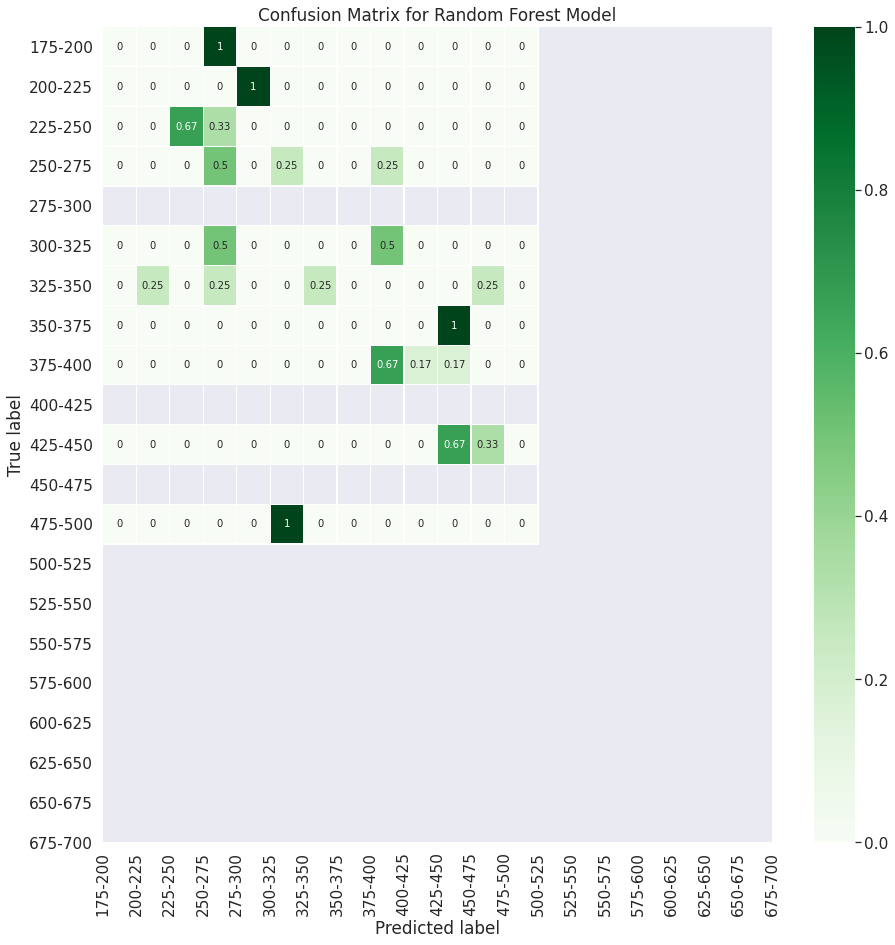

In [378]:
matrix = confusion_matrix(Y_test, Y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15,15))
sn.set(font_scale=1.4)
sn.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['175-200', '200-225', '225-250', '250-275', '275-300', '300-325', '325-350', '350-375',
                  '375-400', '400-425', '425-450', '450-475', '475-500', '500-525', '525-550', '550-575', 
                 '575-600', '600-625', '625-650', '650-675', '675-700']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [379]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       1.00      0.67      0.80         3
           3       0.33      0.50      0.40         4
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         2
           7       1.00      0.25      0.40         4
           8       0.00      0.00      0.00         1
           9       0.67      0.67      0.67         6
          10       0.00      0.00      0.00         0
          11       0.50      0.67      0.57         3
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         1

    accuracy                           0.42        26
   macro avg       0.27      0.21      0.22        26
weighted avg       0.53      0.42      0.44        26



/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As confirmed by the report and the confusion matrix there are many predictions that are misclassified.

## 5. Hyperparameters tuning

Since our model can be set with some parameters, we are going to look for the best ones, first with a RandomizedSearchCV and then with a GridSearchCV.

### 5.1 RandomizedSearchCV

In [380]:
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 299,
 'verbose': 0,
 'warm_start': False}


We define the ranges of the hyperparameters.

In [381]:
bootstrap = [True, False]
ccp_alpha = uniform(0.01, 0.99)
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(1, 100, num = 100)]
max_depth.append(None)
max_features = truncnorm(a = 0, b = 1, loc = 0.25, scale = 0.1)
max_leaf_nodes = [int(x) for x in np.linspace(1, 100, num = 100)]
max_leaf_nodes.append(None)
min_impurity_decrease = uniform(0.01, 0.99)
min_samples_leaf = randint(1, 20)
min_samples_split = uniform(0.01, 0.199)
n_estimators = randint(1, 200)
oob_score = [True, False]
random_state = randint(1, 400)
warm_start = [True, False]

In [382]:
random_grid = {'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha,
               'criterion': criterion,
               'max_depth': max_depth,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
               'n_estimators': n_estimators,
               'oob_score': oob_score,
               'random_state': random_state,
               'warm_start': warm_start}

In [383]:
clf_tmp = RandomForestClassifier()

We launch the search function and then create a model to evaluate its accuracy.

In [384]:
clf_ran = RandomizedSearchCV(clf_tmp, param_distributions = random_grid, n_iter = 100,
                             random_state = 42, n_jobs = -1)
best_model = clf_ran.fit(X_train, Y_train)

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [385]:
pprint(best_model.best_estimator_.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.2486152113657516,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 71,
 'max_features': array([0.30481896]),
 'max_leaf_nodes': 8,
 'max_samples': None,
 'min_impurity_decrease': 0.044044635904066216,
 'min_impurity_split': None,
 'min_samples_leaf': 14,
 'min_samples_split': 0.08782106090707492,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 388,
 'verbose': 0,
 'warm_start': False}


In [386]:
temp_model = RandomForestClassifier(bootstrap = False, ccp_alpha = 0.2486152113657516, class_weight =  None,
                                    criterion = 'entropy', max_depth = 71, max_features = 0.30481896,
                                    max_leaf_nodes = 8, max_samples = None,
                                    min_impurity_decrease = 0.044044635904066216, min_impurity_split = None,
                                    min_samples_leaf = 14, min_samples_split = 0.08782106090707492,
                                    min_weight_fraction_leaf = 0.0, n_estimators = 100, n_jobs = -1,
                                    oob_score = False, random_state = 388, verbose = 0, warm_start = False)
temp_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.2486152113657516,
                       criterion='entropy', max_depth=71,
                       max_features=0.30481896, max_leaf_nodes=8,
                       min_impurity_decrease=0.044044635904066216,
                       min_samples_leaf=14,
                       min_samples_split=0.08782106090707492, n_jobs=-1,
                       random_state=388)

In [387]:
models.append('RandomizedSearchCV')

In [388]:
Y_pred_temp = temp_model.predict(X_test)

In [389]:
Y_pred_temp

array([9, 9, 9, 3, 3, 9, 9, 9, 3, 9, 3, 9, 9, 9, 3, 9, 3, 3, 9, 9, 3, 9,
       9, 3, 9, 9])

In [390]:
Y_test

array([ 9,  3, 14,  3,  1, 11,  9,  7,  2,  7,  2,  7,  9,  9,  2,  5,  0,
        7,  8, 11,  5,  9,  9,  3,  3, 11])

In [391]:
temp_accuracy = temp_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (temp_accuracy*100.0))

Accuracy: 30.769%


In [392]:
accuracies.append(temp_accuracy*100.0)

Unfortunately our accuracy has become even worse than the previous one.

### 5.2 GridSearchCV

We try now with a different search function on a more restricted range of hyperparameters.

In [393]:
max_depth = [2, 5, 10, 20, 30]
max_depth.append(None)
max_features = ['auto', 'log2']
max_features.append(None)
min_samples_leaf = [1, 2, 3, 4, 5, 6]
min_samples_split = [3, 4, 5, 6]

In [394]:
param_grid = {'max_depth': max_depth,
              'max_features': max_features,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split
             }

In [395]:
clf_grid = GridSearchCV(clf_tmp, param_grid = param_grid)

In [396]:
best_grid = clf_grid.fit(X_train, Y_train)

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [397]:
pprint(best_grid.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


As we have done before we are going to evaluate the accuracy of this new model.

In [398]:
temp_grid = RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0, class_weight =  None,
                                    criterion = 'gini', max_depth = 2, max_features = 17,
                                    max_leaf_nodes = None, max_samples = None,
                                    min_impurity_decrease = 0.008, min_impurity_split = None,
                                    min_samples_leaf = 6, min_samples_split = 2,
                                    min_weight_fraction_leaf = 0.0, n_estimators = 100, n_jobs = -1,
                                    oob_score = False, random_state = 314, verbose = 0, warm_start = False)
temp_grid.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, max_features=17,
                       min_impurity_decrease=0.008, min_samples_leaf=6,
                       n_jobs=-1, random_state=314)

In [399]:
models.append('GridSearchCV')

In [400]:
Y_pred_temp = temp_grid.predict(X_test)

In [401]:
Y_pred_temp

array([ 9,  9,  9,  3,  3, 11,  9, 11,  3,  9,  3,  9,  9,  9,  3,  9,  3,
        3,  9, 11,  3,  9,  9,  3, 11,  9])

In [402]:
Y_test

array([ 9,  3, 14,  3,  1, 11,  9,  7,  2,  7,  2,  7,  9,  9,  2,  5,  0,
        7,  8, 11,  5,  9,  9,  3,  3, 11])

In [403]:
temp_grid_accuracy = temp_grid.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (temp_grid_accuracy*100.0))

Accuracy: 38.462%


In [404]:
accuracies.append(temp_grid_accuracy*100.0)

The accuracy is still very low, even though we have put our efforts in tuning the parameters we are not performing better than a simple RandomForestClassifier. What we have left to do is to compare other classification algos and if none of them is able to perform better we just have to accept that our dataset is poor, and might consider to expand it.

## 6. Comparing algorithms

### 6.1 KNN

In [405]:
from sklearn.neighbors import KNeighborsClassifier

In [406]:
KNN_model = KNeighborsClassifier(n_neighbors = 5, algorithm = 'ball_tree', leaf_size = 3)
KNN_model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=3)

In [407]:
models.append('KNN')

In [408]:
KNN_accuracy = KNN_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (KNN_accuracy*100.0))

Accuracy: 46.154%


In [409]:
accuracies.append(KNN_accuracy*100.0)

In [410]:
Y_pred = KNN_model.predict(X_test)

In [411]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      0.33      0.40         3
           3       0.38      0.75      0.50         4
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         1
           9       0.86      1.00      0.92         6
          11       0.67      0.67      0.67         3
          14       0.00      0.00      0.00         1

    accuracy                           0.46        26
   macro avg       0.22      0.25      0.23        26
weighted avg       0.39      0.46      0.41        26



/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6.2 SVC

In [412]:
from sklearn.svm import SVC

In [413]:
SVC_model = SVC(kernel = 'linear')
SVC_model.fit(X_train, Y_train)

SVC(kernel='linear')

In [414]:
models.append('SVC')

In [415]:
SVC_accuracy = SVC_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (SVC_accuracy*100.0))

Accuracy: 46.154%


In [416]:
accuracies.append(SVC_accuracy*100.0)

In [417]:
Y_pred = SVC_model.predict(X_test)

In [418]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.67      0.67      0.67         3
           3       0.40      0.50      0.44         4
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         2
           7       0.50      0.25      0.33         4
           8       0.00      0.00      0.00         1
           9       0.56      0.83      0.67         6
          11       0.50      0.67      0.57         3
          14       0.00      0.00      0.00         1

    accuracy                           0.46        26
   macro avg       0.24      0.27      0.24        26
weighted avg       0.40      0.46      0.42        26



/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6.3 Naive Bayes

In [419]:
from sklearn.naive_bayes import MultinomialNB

In [420]:
MNB_model = MultinomialNB()
MNB_model.fit(X_train, Y_train)

MultinomialNB()

In [421]:
models.append('MultinomialNB')

In [422]:
MNB_accuracy = MNB_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (MNB_accuracy*100.0))

Accuracy: 50.000%


In [423]:
accuracies.append(MNB_accuracy*100.0)

In [424]:
from sklearn.naive_bayes import GaussianNB

In [425]:
GNB_model = GaussianNB(var_smoothing = 1.057)
GNB_model.fit(X_train, Y_train)

GaussianNB(var_smoothing=1.057)

In [426]:
models.append('GaussianNB')

In [427]:
GNB_accuracy = GNB_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (GNB_accuracy*100.0))

Accuracy: 53.846%


In [428]:
accuracies.append(GNB_accuracy*100.0)

### 6.4 Logistic Regression

In [429]:
from sklearn.linear_model import LogisticRegression

In [430]:
LR_model = LogisticRegression(multi_class = 'ovr')
LR_model.fit(X_train, Y_train)

LogisticRegression(multi_class='ovr')

In [431]:
models.append('LogisticRegression')

In [432]:
LR_accuracy = LR_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (LR_accuracy*100.0))

Accuracy: 46.154%


In [433]:
accuracies.append(LR_accuracy*100.0)

### 6.5 One vs Rest Classifier

In [434]:
from sklearn.multiclass import OneVsRestClassifier

In [435]:
OVR_model = OneVsRestClassifier(MultinomialNB())
OVR_model.fit(X_train, Y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [436]:
models.append('OneVsRestClassifier')

In [437]:
OVR_accuracy = OVR_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (OVR_accuracy*100.0))

Accuracy: 50.000%


In [438]:
accuracies.append(OVR_accuracy*100.0)

### 6.6 Ridge Classifier

In [439]:
from sklearn.linear_model import RidgeClassifier

In [440]:
R_model = RidgeClassifier()
R_model.fit(X_train, Y_train)

RidgeClassifier()

In [441]:
models.append('RidgeClassifier')

In [442]:
R_accuracy = R_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (R_accuracy*100.0))

Accuracy: 46.154%


In [443]:
accuracies.append(R_accuracy*100.0)

### 6.7 Passive Aggressive Classifier

In [444]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [445]:
PA_model = PassiveAggressiveClassifier(random_state = 90)
PA_model.fit(X_train, Y_train)

PassiveAggressiveClassifier(random_state=90)

In [446]:
models.append('PassiveAggressiveClassifier')

In [447]:
PA_accuracy = PA_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (PA_accuracy*100.0))

Accuracy: 53.846%


In [448]:
accuracies.append(PA_accuracy*100.0)

### 6.8 Bagging Classifier

In [449]:
from sklearn.ensemble import BaggingClassifier

In [450]:
B_model = BaggingClassifier(random_state = 4, n_estimators = 99)
B_model.fit(X_train, Y_train)

BaggingClassifier(n_estimators=99, random_state=4)

In [451]:
models.append('BaggingClassifier')

In [452]:
B_accuracy = B_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (B_accuracy*100.0))

Accuracy: 42.308%


In [453]:
accuracies.append(B_accuracy*100.0)

### 6.9 Gradient Boosting Classifier

In [454]:
from sklearn.ensemble import GradientBoostingClassifier

In [455]:
GB_model = GradientBoostingClassifier(learning_rate = 0.021)
GB_model.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=0.021)

In [456]:
models.append('GradientBoostingClassifier')

In [457]:
GB_accuracy = GB_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (GB_accuracy*100.0))

Accuracy: 42.308%


In [458]:
accuracies.append(GB_accuracy*100.0)

### 6.10 AdaBoost Classifier

In [459]:
from sklearn.ensemble import AdaBoostClassifier

In [460]:
A_model = AdaBoostClassifier(random_state = 24, learning_rate = 0.190)
A_model.fit(X_train, Y_train)

AdaBoostClassifier(learning_rate=0.19, random_state=24)

In [461]:
models.append('AdaBoostClassifier')

In [462]:
A_accuracy = A_model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (A_accuracy*100.0))

Accuracy: 42.308%


In [463]:
accuracies.append(A_accuracy*100.0)

## 7. Summary

Let's have a look to all the models we have trained so far and the try to make our conclusions.

In [464]:
for i in range(0, 13):
    print("Model: " + models[i] + '\n' + "Accuracy: %.3f%%" % accuracies[i] + '\n')

Model: RandomForestClassifier
Accuracy: 42.308%

Model: RandomizedSearchCV
Accuracy: 30.769%

Model: GridSearchCV
Accuracy: 38.462%

Model: KNN
Accuracy: 46.154%

Model: SVC
Accuracy: 46.154%

Model: MultinomialNB
Accuracy: 50.000%

Model: GaussianNB
Accuracy: 53.846%

Model: LogisticRegression
Accuracy: 46.154%

Model: OneVsRestClassifier
Accuracy: 50.000%

Model: RidgeClassifier
Accuracy: 46.154%

Model: PassiveAggressiveClassifier
Accuracy: 53.846%

Model: BaggingClassifier
Accuracy: 42.308%

Model: GradientBoostingClassifier
Accuracy: 42.308%



It is clear now that whichever model we are considering we cannot gain such a great accuracy. All we have to do is to work on our data.

## 8. Feature scaling

Maybe we have understimated the power of feature scaling, just give it a try.

In [465]:
from sklearn.preprocessing import StandardScaler, scale

In [466]:
X_train_scal = scale(X_train)
X_train_scal

array([[-0.43792787, -0.10783277,  1.4327008 , ..., -0.21952852,
        -0.27216553, -0.38044296],
       [-0.43792787, -0.10783277, -0.69798244, ..., -0.21952852,
        -0.27216553, -0.38044296],
       [-0.43792787, -0.10783277, -0.69798244, ..., -0.21952852,
        -0.27216553, -0.38044296],
       ...,
       [-0.43792787, -0.10783277, -0.69798244, ..., -0.21952852,
        -0.27216553, -0.38044296],
       [ 2.28348105, -0.10783277,  1.4327008 , ..., -0.21952852,
        -0.27216553,  2.62851496],
       [-0.43792787, -0.10783277, -0.69798244, ..., -0.21952852,
        -0.27216553,  2.62851496]])

In [467]:
scaler = StandardScaler().fit(X_train)

In [468]:
X_test_scal = scaler.transform(X_test)
X_test_scal

array([[ 2.28348105, -0.10783277, -0.69798244, -0.74228325, -1.04708431,
         1.04708431, -0.79130792, -0.35011519,  0.98857105, -0.10783277,
        -0.30714756, -0.07602859, -0.10783277, -0.13245324, -0.29580399,
        -0.17200523, -0.38044296, -0.20473438, -0.20473438, -0.35011519,
        -0.29580399, -0.31822291, -0.13245324, -0.10783277,  4.55521679,
        -0.27216553, -0.38044296],
       [-0.43792787, -0.10783277, -0.69798244,  0.97981389, -1.04708431,
         1.04708431,  1.26373056, -0.35011519, -1.01156108, -0.10783277,
        -0.30714756, -0.07602859, -0.10783277, -0.13245324, -0.29580399,
        -0.17200523, -0.38044296, -0.20473438, -0.20473438, -0.35011519,
         3.38061702, -0.31822291, -0.13245324, -0.10783277, -0.21952852,
        -0.27216553, -0.38044296],
       [-0.43792787, -0.10783277, -0.69798244, -0.74228325, -1.04708431,
         1.04708431, -0.79130792, -0.35011519,  0.98857105, -0.10783277,
        -0.30714756, -0.07602859, -0.10783277, -0.1324

Let's prepare few new models to train with both unscaled and scaled features.

In [469]:
KNN_m = KNeighborsClassifier()
SVC_m = SVC(kernel = 'linear')
GNB_m = GaussianNB()
LR_m = LogisticRegression()
R_m = RidgeClassifier()
PA_m = PassiveAggressiveClassifier()
B_m = BaggingClassifier()
GB_m = GradientBoostingClassifier()
A_m = AdaBoostClassifier()

In [470]:
scal_models = [KNN_m, SVC_m, GNB_m, LR_m, R_m, PA_m, B_m, GB_m, A_m]
scal_models

[KNeighborsClassifier(),
 SVC(kernel='linear'),
 GaussianNB(),
 LogisticRegression(),
 RidgeClassifier(),
 PassiveAggressiveClassifier(),
 BaggingClassifier(),
 GradientBoostingClassifier(),
 AdaBoostClassifier()]

In [471]:
accuracies_not_scaled = []
accuracies_sacaled = []

for model in scal_models:
    model.fit(X_train, Y_train)
    accuracy = model.score(X_test, Y_test)
    accuracies_not_scaled.append(accuracy)
    model.fit(X_train_scal, Y_train)
    accuracy_scal = model.score(X_test_scal, Y_test)
    accuracies_scaled.append(accuracy_scal)
    print("Model: " + str(model) + '\n' + "Accuracy: %.3f%%" % (accuracy*100.0) + '\n' +
          "Accuracy scaled: %.3f%%" % (accuracy_scal*100.0) + '\n')

Model: KNeighborsClassifier()
Accuracy: 42.308%
Accuracy scaled: 26.923%

Model: SVC(kernel='linear')
Accuracy: 46.154%
Accuracy scaled: 38.462%

Model: GaussianNB()
Accuracy: 7.692%
Accuracy scaled: 7.692%

Model: LogisticRegression()
Accuracy: 42.308%
Accuracy scaled: 38.462%

Model: RidgeClassifier()
Accuracy: 46.154%
Accuracy scaled: 42.308%

Model: PassiveAggressiveClassifier()
Accuracy: 23.077%
Accuracy scaled: 7.692%

Model: BaggingClassifier()
Accuracy: 30.769%
Accuracy scaled: 26.923%

Model: GradientBoostingClassifier()
Accuracy: 26.923%
Accuracy scaled: 19.231%

Model: AdaBoostClassifier()
Accuracy: 26.923%
Accuracy scaled: 23.077%



As we can see algos with scaled features perform even worse in this case. There is not very much left to do, apart from increasing our dataset.